# ENSEMBLE OF FORECASTERS
__Authors__
- Luca Guffanti
- Giorgio Daneri
- Daniele Ferrario

## MPI Parallelization
The MPI parallelization focuses on the even distribution of the workload among the available processes. The main idea is to deploy a predefined number 
of forecasters on each process, letting them work independently on the available data through the training and inference phases. Final predictions are then aggregated with the learnt weights and biases, and a statistical analysis is performed to evaluate the performance of the ensemble.

The engineered solution consists in a wrapper class, `MPIDistributionStrategy`, that is responsible for the distribution of the workload and the orchestration of the parallel agents. When constructed, `MPIDistributionStrategy` requires passing a type of forecaster to be used, which must be
a type name that inherits from the abstract `ForecasterBase` object, implementing methods for training and inference, and exposing a gradient computation function. Thus, the original ARNN forecaster proposed in `seq.py` has been turned into and object, and is the implementation on which the native MPI approach was tested on.

## Analysis of the weights
A generic weight $w_{ij}$ describes the contribution of the $j$-th window variable on the $i$-th feature.  

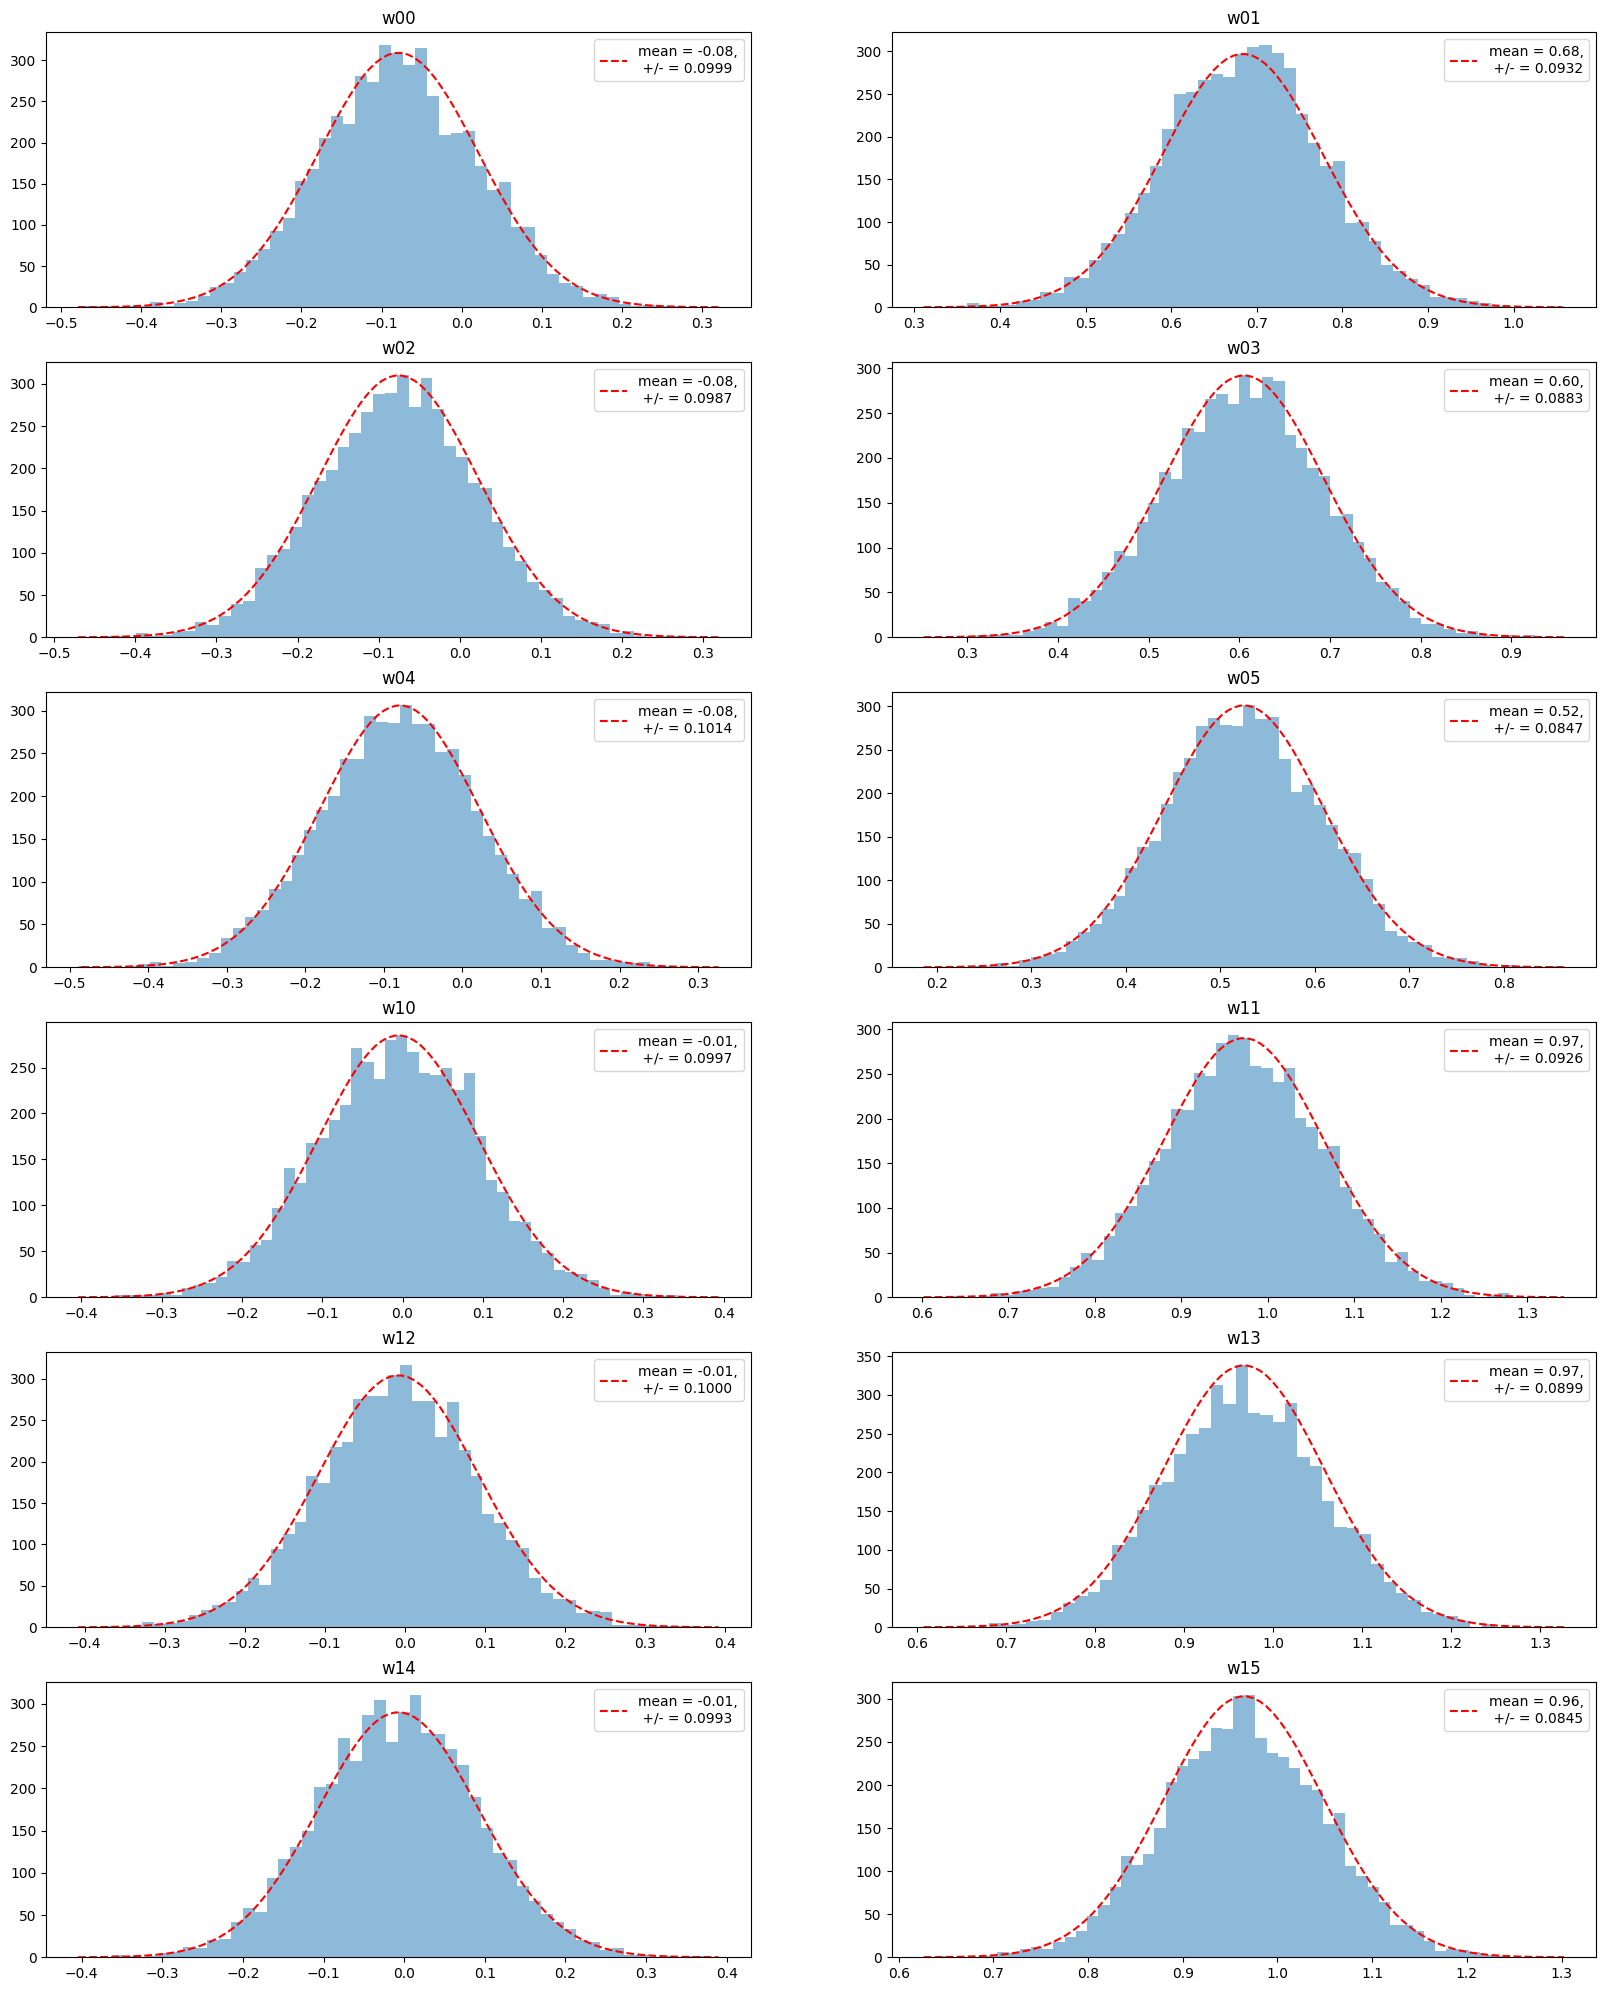

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv('weights.csv')

# Create a figure with 12 subplots
fig, axs = plt.subplots(6, 2, figsize=(20, 25))  

# On the i-th axis, plot the i-th column of the data
for i, ax in enumerate(axs.flat):
    hist_values, bin_edges, _ = ax.hist(df.iloc[:, i+1], bins=50, alpha=0.5)
    
    # Superimpose a gaussian distribution with the same mean and standard deviation
    mean = df.iloc[:, i+1].mean()
    std = df.iloc[:, i+1].std()
    x = np.linspace(mean - 4*std, mean + 4*std, 100)
    y = 1/(std * np.sqrt(2 * np.pi)) * np.exp(-0.5 * (x - mean)**2 / std**2)
    # Rescale the gaussian so that it fits the histogram distribution. This means, set the maximum of the gaussian to the maximum value of the histogram
    
    bin_width = bin_edges[1] - bin_edges[0]
    mean_bin_index = np.digitize(mean, bin_edges) - 1  # Get the bin containing the mean
    mean_bin_height = hist_values[mean_bin_index]

    y_rescaled = y * mean_bin_height / (1/(std * np.sqrt(2 * np.pi)))
    
    ax.plot(x, y_rescaled, 'r--', label='mean = {:.2f},\n +/- = {:.4f}'.format(mean, std), )
    ax.legend(loc='upper right')
    ax.set_title(df.columns[i+1])

As it can be seen, weights adopt an (almost standardized) Gaussian distribution.

## Analysis of the biases
All biases are aggregated in a single plot, which is shown below

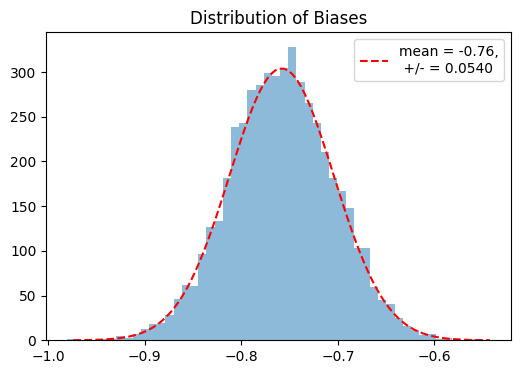

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('biases.csv')
# Create a figure with a single subplot
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
# Plot the data
hist_values, bin_edges, _ = ax.hist(df.iloc[:, 1], bins=50, alpha=0.5)
ax.set_title("Distribution of Biases")
# Superimpose a gaussian distribution with the same mean and standard deviation
mean = df.iloc[:, 1].mean()
std = df.iloc[:, 1].std()
x = np.linspace(mean - 4*std, mean + 4*std, 100)
y = 1/(std * np.sqrt(2 * np.pi)) * np.exp(-0.5 * (x - mean)**2 / std**2)
# Rescale the gaussian so that it fits the histogram distribution. This means, set the maximum of the gaussian to the maximum value of the histogram
bin_width = bin_edges[1] - bin_edges[0]
mean_bin_index = np.digitize(mean, bin_edges) - 1  # Get the bin containing the mean
mean_bin_height = hist_values[mean_bin_index]
y_rescaled = y * mean_bin_height / (1/(std * np.sqrt(2 * np.pi)))
ax.plot(x, y_rescaled, 'r--', label='mean = {:.2f},\n +/- = {:.4f}'.format(mean, std))
ax.legend(loc='upper right')


plt.show()

Again, we can observe a Gaussian distribution.

## Analysis of the predictions

Plots for prediction are shown below and are grouped horizontally by features and vertically by prediction step. 

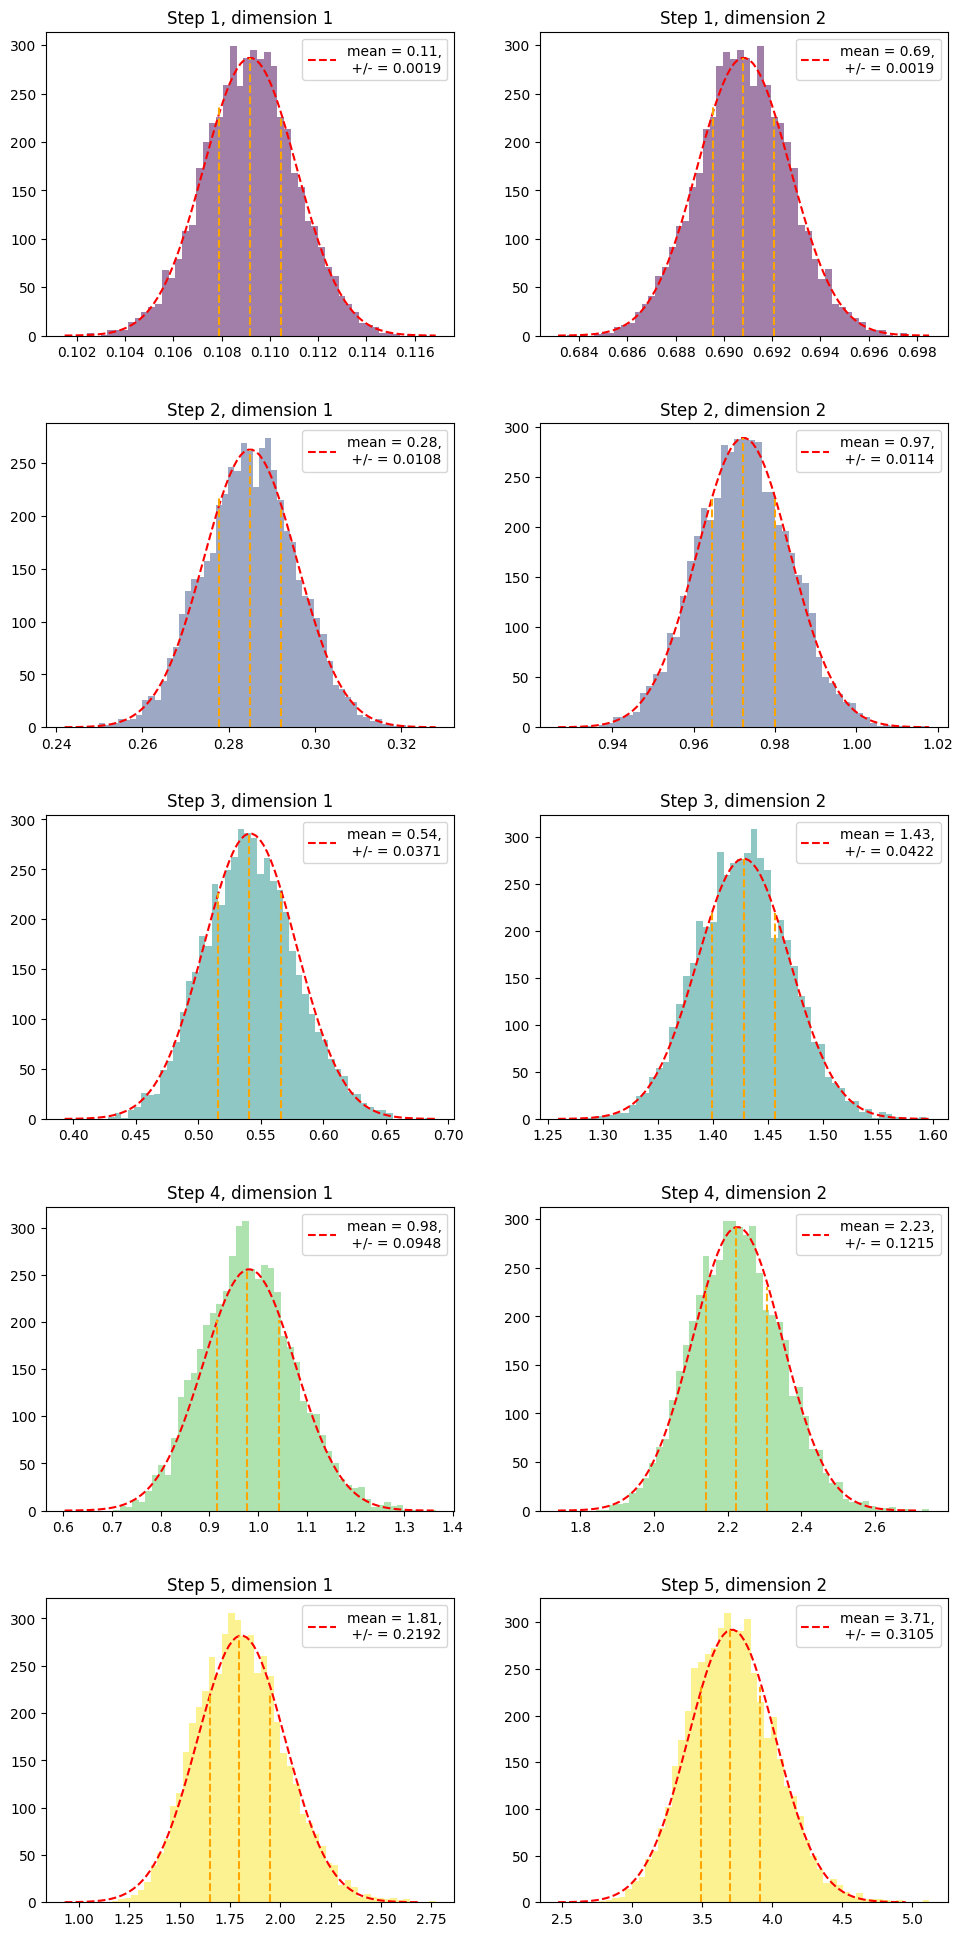

In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('predictions.csv')
# Create a figure with a number of subplots equal to the maximum of the first column
fig, axs = plt.subplots(df.iloc[:, 0].max()+1, 2, figsize=(10, 20))

# define a colormap with a number of colors equal to the maximum in the first column
colors = plt.cm.viridis(np.linspace(0, 1, df.iloc[:, 0].max()+1))

# Plot the data
for i in range(0, df.iloc[:, 0].max()+1):
    for j in range(2):
        hist_values, bin_edges, _ = axs[i, j].hist(df[df.iloc[:, 0] == i].iloc[:, j+1], bins=50, color=colors[i], alpha=0.5)
        axs[i, j].set_title(f"Step {i+1}, dimension {j+1}")

        # Superimpose a gaussian distribution with the same mean and standard deviation
        mean = df[df.iloc[:, 0] == i].iloc[:, j+1].mean()
        std = df[df.iloc[:, 0] == i].iloc[:, j+1].std()
        x = np.linspace(mean - 4*std, mean + 4*std, 100)
        y = 1/(std * np.sqrt(2 * np.pi)) * np.exp(-0.5 * (x - mean)**2 / std**2)
        # Rescale the gaussian so that it fits the histogram distribution. This means, set the maximum of the gaussian to the maximum value of the histogram
        bin_width = bin_edges[1] - bin_edges[0]
        mean_bin_index = np.digitize(mean, bin_edges) - 1
        mean_bin_height = hist_values[mean_bin_index]
        y_rescaled = y * mean_bin_height / (1/(std * np.sqrt(2 * np.pi)))
        axs[i, j].plot(x, y_rescaled, 'r--', label='mean = {:.2f},\n +/- = {:.4f}'.format(mean, std))
        axs[i, j].legend(loc='upper right')

        # Add the quantiles to the plot as vertical lines and stop them when they reach the gaussian curve
        quantiles = np.quantile(df[df.iloc[:, 0] == i].iloc[:, j+1], [0.25, 0.50, 0.75])
        for quantile in quantiles:
            axs[i, j].add_line(plt.Line2D([quantile, quantile], [0, y_rescaled[np.searchsorted(x, quantile)]], color='orange', linestyle='--'))

# Add the title to the entire plot
fig.suptitle("")
plt.tight_layout(h_pad=3, pad=2)


Again, the distribution is Gaussian, and it can be noted that the standard deviation increases with the prediction step. This is expected, as advancing in time has a cumulative effect on the uncertainties in the predictions. The lines in orange are the quartiles of the distribution.

Text(0.5, 0.98, 'Distribution of Predictions as steps increase')

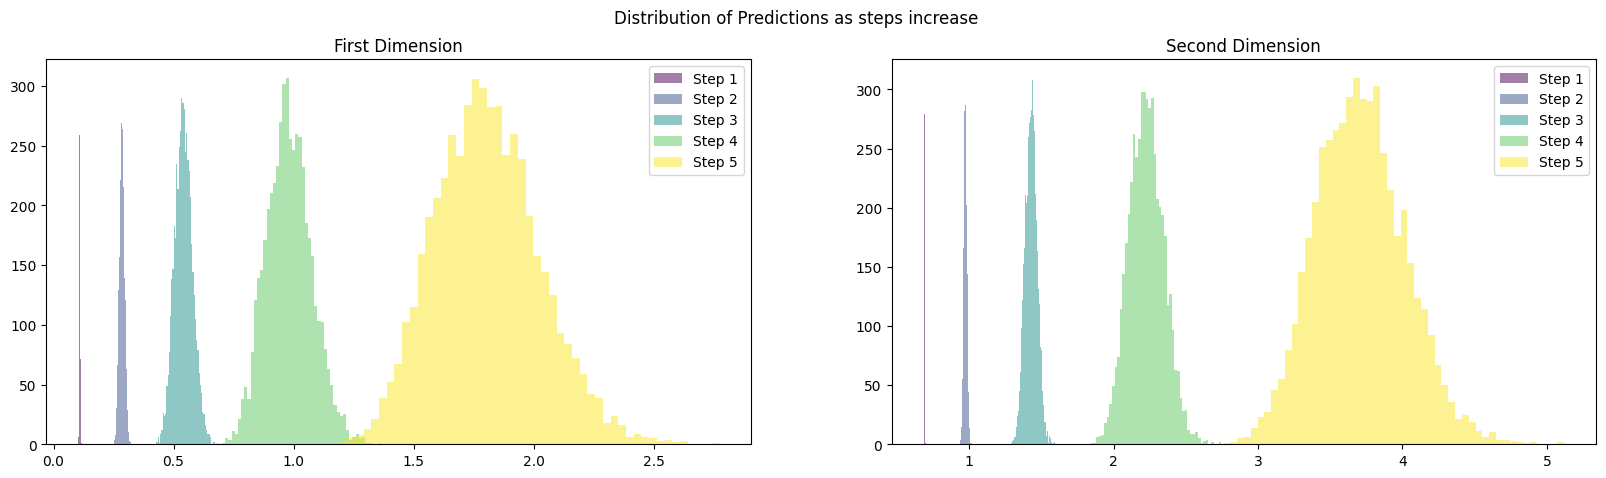

In [105]:
# Build a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Plot all the data related to separate steps in the first dimensions
for i in range(0, df.iloc[:, 0].max()+1):
    axs[0].hist(df[df.iloc[:, 0] == i].iloc[:, 1], bins=50, alpha=0.5, label=f"Step {i+1}", color=colors[i])

# Plot all the data related to separate steps in the second dimensions
for i in range(0, df.iloc[:, 0].max()+1):
    axs[1].hist(df[df.iloc[:, 0] == i].iloc[:, 2], bins=50, alpha=0.5, label=f"Step {i+1}", color=colors[i])
# Add the legend

axs[0].set_title("First Dimension")
axs[1].set_title("Second Dimension")
axs[0].legend()
axs[1].legend()
plt.suptitle("Distribution of Predictions as steps increase")


This last plot visualizes the added uncertainty due to the evolution in time